In [1]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap

from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
from torchvision import transforms

from src.datasets.mnist import MNIST
from src.datasets.splitting import split_dataset

#from src.models import TopologicallyRegularizedAutoencoder

torch.manual_seed(42)

In [2]:
# LOAD DATASET:
dataset = MNIST(train=True)

In [3]:
# SPLIT DATASET:
val_size = 0.2
batch_size = 64

train_loader, validation_loader, test_loader = split_dataset(dataset, val_size, batch_size)


In [4]:
# CHOOSE SPLIT:
index = 1 # to choose split
splits = ['train','val','test']
dataloaders = [train_loader, validation_loader, test_loader]
loader_dict = {key:item for key,item in zip(splits, dataloaders)}

dataloader =  loader_dict[splits[index]]

In [5]:
dataloader

In [6]:
from IPython import embed

def get_latent_space(model, dataset, batch_size=64, val_size=0.2):
        
    #ensure that seed is correct (despite several function calls)
    torch.manual_seed(42)
    #need to setup dataloader for each method as surrogate uses bs 32.. 
    train_loader, validation_loader, test_loader = split_dataset(dataset, val_size, batch_size)
    data_loader = train_loader 
    
    full_latent_space = []
    all_labels = []

    for index, batch in enumerate(dataloader):
        image, label = batch
        #latent, reconst = model(image)
        latent = model.encode(image)
        reconst = model.decode(latent)
        
        
        latent = latent.detach().numpy()
        latent_flat = latent.reshape(latent.shape[0], -1)
        print(f'Latent Batch Shape: {latent_flat.shape}')
        
        reconst = reconst.detach().numpy()
        
        ##BUG:
        ##latent_flat = latent.reshape(-1, latent.shape[0]).T
        
        full_latent_space.append(latent_flat)
        all_labels.append(label)

        #if index == 199:
        #    break

    full_latent_space = np.concatenate(full_latent_space, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return [full_latent_space, all_labels]

In [7]:
#Extract full data space for baseline t-sne:
full_data_space = []
all_labels = []
torch.manual_seed(42)
for index, batch in enumerate(dataloader):
    image, label = batch
    im = image.detach().numpy()
        
    im_flat = im.reshape(im.shape[0], -1)
    
    full_data_space.append(im_flat)
    all_labels.append(label)
    #if index == 50:
    #    break
    
full_data_space = np.concatenate(full_data_space, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [8]:
full_data_space.shape

(12000, 784)

In [9]:
from sklearn.preprocessing import StandardScaler

def rescaled(data):
    return StandardScaler().fit_transform(data)

In [10]:
# LOAD ALL MODELS AND GET LATENT SPACES
methods = ['topological','vanilla', 'surrogate'] #'surrogate'
model_paths = {methods[0]: '../runs/mnist/6/model.pth', #1=10 epochs, 6=50   
                methods[1]: '../runs/mnist/5/model.pth', #3=10 epochs, 5=50
               methods[2]: '../runs/mnist/4/model.pth'
              }

latent_spaces = {}

for method in methods:    
    model = torch.load(model_paths[method])
    
    # GET LATENT SPACES:
    print(f'Get latent space of {method} model')
    if method == 'surrogate': #use bs 32 as model was trained to bs 32 due to bad scaling..
        Z, _labels = get_latent_space(model, dataset, batch_size=32)
    else:
        Z, _labels = get_latent_space(model, dataset)
    #ensure that _labels are identical to all_labels, due to seed issues:
    if (all_labels != _labels).sum() > 0:
        raise ValueError('Labels are not consistent! Fix seeds!')
    latent_spaces[method] = {'data': Z, 'labels': _labels}

Get latent space of topological model
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Laten

Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch Shape: (64, 32)
Latent Batch S

array([5, 3, 2, ..., 6, 5, 0])

In [56]:
n_samples = 5000

In [23]:
latent_spaces['topological']['data'][:n_samples,:].shape

(1000, 32)

In [57]:
# Scale and subset samples:

topo_latent = rescaled( 
    latent_spaces['topological']['data'][:n_samples,:] 
)    
vanilla_latent = rescaled( 
    latent_spaces['vanilla']['data'][:n_samples,:]
)
surr_latent = rescaled( 
    latent_spaces['surrogate']['data'][:n_samples,:] 
)    

data_scaled = rescaled(  
    full_data_space[:n_samples,:]
)

used_labels = all_labels[:n_samples]

In [50]:
tsne = TSNE(random_state=42, perplexity=20) #, perplexity=10, learning_rate=100, early_exaggeration=30)
Z_tsne_top = tsne.fit_transform(topo_latent)

tsne = TSNE(random_state=42, perplexity=20) #, perplexity=10, learning_rate=100)
Z_tsne_van = tsne.fit_transform(vanilla_latent)

tsne = TSNE(random_state=42, perplexity=20) #, perplexity=10, learning_rate=100)
X_tsne = tsne.fit_transform(data_scaled)
#scaled_data_space

In [51]:
tsne = TSNE(random_state=42, perplexity=20) #, perplexity=10, learning_rate=100, early_exaggeration=30)
Z_tsne_surr = tsne.fit_transform(surr_latent)

In [52]:
pca = PCA(random_state=0)
Z_pca_top = pca.fit_transform(topo_latent)

pca = PCA(random_state=0)
Z_pca_van = pca.fit_transform(vanilla_latent)

pca = PCA(random_state=0)
Z_pca_surr = pca.fit_transform(surr_latent)

pca = PCA(random_state=0)
X_pca = pca.fit_transform(data_scaled)

In [13]:
def plotting(transformed, all_labels, title):
    color_mapping = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
    distinct_labels = np.unique(all_labels)
    colors = [color_mapping[cl] for cl in distinct_labels]
    for i, label in enumerate(distinct_labels):
        mask = (all_labels == label).astype(int)
        inds = list(np.where(mask)[0])
        plt.scatter(transformed[inds, 0], transformed[inds, 1], c=[colors[i]], label=label, s=2)
    plt.title(title)
    lgnd = plt.legend(loc="lower left")
    for i,_ in enumerate(distinct_labels):
        lgnd.legendHandles[i]._sizes = [30]

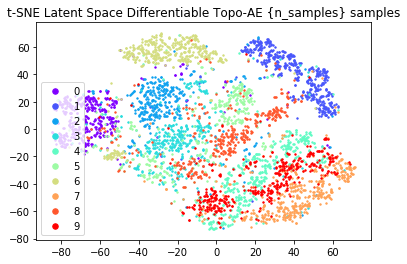

In [54]:
plotting(Z_tsne_top, all_labels[:n_samples], 't-SNE Latent Space Differentiable Topo-AE {n_samples} samples')


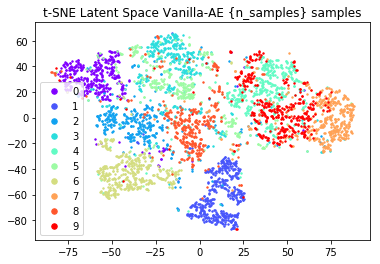

In [55]:
plotting(Z_tsne_van, all_labels[:n_samples], 't-SNE Latent Space Vanilla-AE {n_samples} samples')

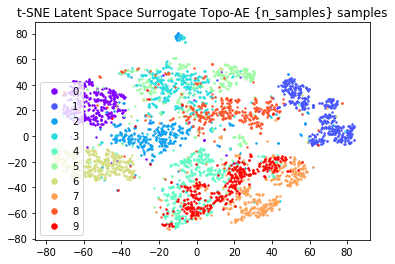

In [56]:
plotting(Z_tsne_surr, all_labels[:n_samples], 't-SNE Latent Space Surrogate Topo-AE {n_samples} samples')

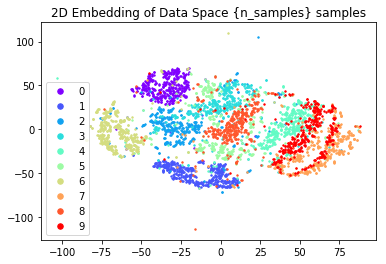

In [57]:
plotting(X_tsne, all_labels[:n_samples], '2D Embedding of Data Space {n_samples} samples')

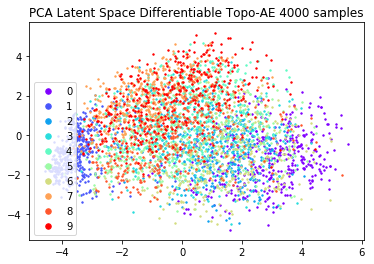

In [71]:
plotting(Z_pca_top, all_labels[:n_samples], f'PCA Latent Space Differentiable Topo-AE {n_samples} samples')

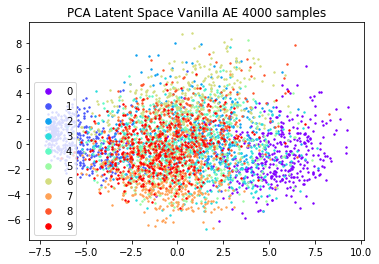

In [72]:
plotting(Z_pca_van, all_labels[:n_samples], f'PCA Latent Space Vanilla AE {n_samples} samples')

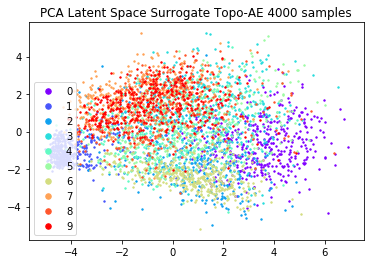

In [73]:
plotting(Z_pca_surr, all_labels[:n_samples], f'PCA Latent Space Surrogate Topo-AE {n_samples} samples')

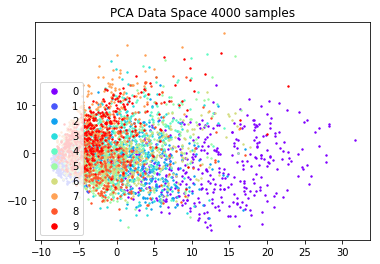

In [74]:
plotting(X_pca, all_labels[:n_samples], f'PCA Data Space {n_samples} samples')

In [16]:
# Latent Space Evaluation Scenario:
from sklearn.neighbors import NearestNeighbors

def get_k_nb(X, k=2):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(X) #'ball_tree'
    distances, indices = nbrs.kneighbors(X)
    return distances, indices

In [17]:
# Majority Voting Function (hard vote, random choice upon ties)
def make_vote(labels):
    unique, counts = np.unique(labels, return_counts=True)
    #deterministic &biased: vote = [x for _,x in sorted(zip(counts,unique))[::-1] ]
    max_count = max(counts) #we choose randomized vote for ties
    winners = np.where(counts == max_count)
    vote_ind = np.random.choice(winners[0], 1)
    vote = unique[vote_ind]
    return vote
    

In [18]:
# Function to retrieve NN label predictions by sequentially including up to k neighbors:
def get_k_predictions(X, y, k=10):
    # Loop to get all k neighboring labels for k-resolved label votes:
    n_neighbors = k

    #determine neighborhood of each sample: #[ n_samples x n_neighbors ] 
    distances, indices = get_k_nb(X, n_neighbors)

    #get labels of neighborhood [ n_samples x n_neighbors-1]  --> we drop the original data point
    neighboring_labels = y[indices][:,1:] 

    #Loop for voting:
    predicted_labels = np.empty([n_samples, n_neighbors-1])
    for k in np.arange(n_neighbors-1):
        for i in np.arange(n_samples):
            labels = neighboring_labels[i,:k+1]
            y_pred = make_vote(labels) #predicts most frequent label in current neighborhood
            predicted_labels[i,k] = y_pred
    return predicted_labels

In [19]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import accuracy_score

def get_NMI(k_predictions, y_true):
    n_neighbors = k_predictions.shape[1]
    k_NMI = np.zeros(n_neighbors)
    for k in np.arange(n_neighbors):
        k_NMI[k] = normalized_mutual_info_score(y_true, k_predictions[:,k], average_method='arithmetic')
    return k_NMI


def get_acc(k_predictions, y_true):
    n_neighbors = k_predictions.shape[1]
    k_acc = np.zeros(n_neighbors)
    for k in np.arange(n_neighbors):
        k_acc[k] = accuracy_score(y_true, k_predictions[:,k], normalize=True)
    return k_acc

In [22]:
k_preds = get_k_predictions(topo_latent, used_labels, k=30)

In [23]:
scores = get_NMI(k_preds, used_labels)

In [24]:
accuracies = get_acc(k_preds, used_labels)

# Evaluate Clustering metrics:


In [20]:
def plot_scores(ax, method, embeddings, true_labels, metric, k=40):
    #first get predicted labels (based on up to k neighbors)
    k_preds = get_k_predictions(embeddings[method], true_labels, k=k)
    
    #for each int up to k get a NMI score of how well the neighborhood labels vote for the correct label
    scores = metric(k_preds, used_labels)
    ax.plot( np.arange(1,len(scores)+1), scores, label=method)
    
    return 


In [36]:

methods = ['topological','vanilla', 'surrogate', 'original']

tsne_embeddings = {
            methods[0]: Z_tsne_top,
            methods[1]: Z_tsne_van,
            methods[2]: Z_tsne_surr,
            methods[3]: X_tsne
    
}

f, (ax1, ax2) = plt.subplots(1, 2)
for method in methods:
    plot_scores(ax1, method, tsne_embeddings, used_labels, metric=get_NMI, k=50)

plt.ylim((0., 1)) 
plt.ylabel('Normalized Mutual Information')
plt.xlabel('Number of k Nearest Neighbors for Label Prediction')

plt.legend()

plt.title('Quality of Embedding after applying t-SNE on Latent (or Data) space')
plt.savefig('nmi_scores.pdf')

NameError: name 'Z_tsne_top' is not defined

IndexError: list index out of range

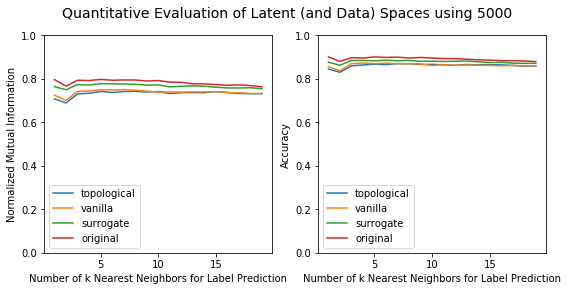

In [58]:
#Neighborhood Scoring without tsne (no visualization! )

methods = ['topological','vanilla', 'surrogate', 'original']

embeddings = {
            methods[0]: topo_latent,
            methods[1]: vanilla_latent,
            methods[2]: surr_latent,
            methods[3]: data_scaled
}    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
for method in methods:
    plot_scores(ax1, method, embeddings, used_labels, metric=get_NMI, k=20)
ax1.set_ylim((0., 1)) 
ax1.set_ylabel('Normalized Mutual Information')
ax1.set_xlabel('Number of k Nearest Neighbors for Label Prediction')
ax1.legend()

for method in methods:
    plot_scores(ax2, method, embeddings, used_labels, metric=get_acc, k=20)
ax2.set_ylim((0., 1)) 
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Number of k Nearest Neighbors for Label Prediction')
ax2.legend()

#plt.legend()
f.suptitle(f"Quantitative Evaluation of Latent (and Data) Spaces using {n_samples}", fontsize=14)

plt.savefig(f'scores_native_{splits[index]}_{n_samples}_samples.pdf') #native latent spaces without additional tsne embedding for visualization




# Testing src version of above notebook code



In [11]:
# testing get_space module (worked once seed is set correctly)
from src.evaluation.utils import get_space
for method in methods:
    model = torch.load(model_paths[method])
    test_space, test_labels = get_space(model, dataloader, mode='latent')
    space_flag = test_space == latent_spaces[method]['data']
    labels_flag = test_labels == latent_spaces[method]['labels']
    print(f'Space Check: {space_flag}')
    print(f'Label Check: {labels_flag}')


Space Check: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
Label Check: [ True  True  True ...  True  True  True]
Space Check: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
Label Check: [ True  True  True ...  True  True  True]
Space Check: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
Label Check: [ True  True  True ...  True  True  True]


In [18]:
#testing eval class
from src.evaluation.eval import Evaluation

eval = Evaluation(method, dataloader, n_samples=500, seed=42, model=model)


In [12]:
test_space, test_labels = eval.get_data()

# BELOW HERE IS OLDER STUFF


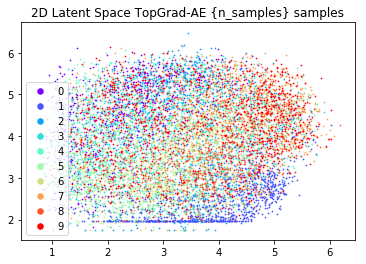

In [15]:
plotting(top_latent_space[:n_samples,:], grad_top_labels[:n_samples], '2D Latent Space TopGrad-AE {n_samples} samples')

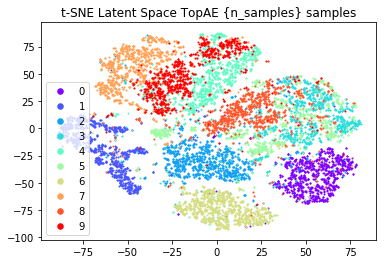

In [89]:
plotting(Z_tsne_top, top_labels[:n_samples], 't-SNE Latent Space TopAE {n_samples} samples')

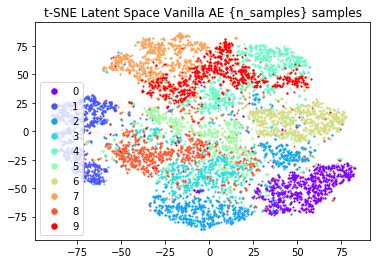

In [90]:
plotting(Z_tsne_van, van_labels[:n_samples], 't-SNE Latent Space Vanilla AE {n_samples} samples')

In [ ]:
mds = MDS(n_components=2)
Z_mds_top = mds.fit_transform(top_latent_space[:n_samples,:])
mds = MDS(n_components=2)
Z_mds_van = mds.fit_transform(vanilla_latent_space[:n_samples,:])

In [ ]:
mds = MDS(n_components=2)
X_mds = mds.fit_transform(full_data_space[:n_samples,:])

In [ ]:
isomap = Isomap(n_components=2)
Z_isomap = isomap.fit_transform(X[:100])

In [27]:
kpca = KernelPCA(kernel="rbf", gamma=1)
Z_kpca = kpca.fit_transform(full_latent_space[:n_samples,:])



In [ ]:
plotting(Z_mds_top, top_labels[:n_samples], f'MDS Latent Space Topological AE {n_samples} samples')

In [ ]:
plotting(Z_mds_van, van_labels[:n_samples], f'MDS Latent Space Vanilla AE {n_samples} samples')

In [ ]:
plotting(X_mds, all_labels[:n_samples], f'MDS Data Space {n_samples} samples')